### EDA on data
--- 

We migrated customer monitoring code from `money-risk-models` to this repo, of which we have already queried data there. To replicate building data, please check out `0-eda-dev-data.ipynb` in this folder.

In [1]:
import sys
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [86]:
# load final data computed locally
# df = pd.read_feather("../../data/combined_all_features/combined_1613851268.feather") 
# we've previous sent combined_1613851268.feather to s3, let's download it
dev_path = "s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-02/dev-data.parquet"
df = pd.read_parquet(dev_path)
df = mu.prep_customer_data(df)

In [87]:
df.shape 

(7384288, 96)

<AxesSubplot:>

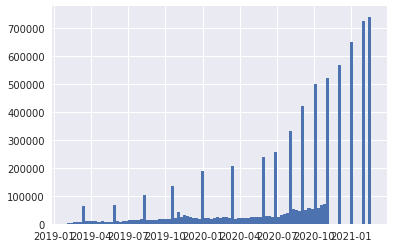

In [32]:
fig = plt.figure(figsize=(6,4))
df.sample_date.hist(bins=100)

In [33]:
df[["indeterminate", "is_static"]].value_counts()

indeterminate  is_static
True           True         4353769
False          False        1863348
               True         1030010
True           False         137161
dtype: int64

In [34]:
df[["indeterminate", "target"]].value_counts()

indeterminate  target
True           False     4344218
False          False     2879123
True           True       146712
False          True        14235
dtype: int64

In [13]:
## data thomas built

df_tb = pd.read_feather("s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/data/dev_data/modeling_df_final_2020-05-14.feather")
df_jxu = pd.read_feather("s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/data/dev_data/modeling_df_replication_for_governance.feather")

In [17]:
print("indeterminate" in df_tb.columns)
print("indeterminate" in df_jxu.columns)

False
True


### Sampling Methods
---

In production, the model will be evaluated on the entire group users at a given snapshot time, but we cannot simply take this approach when building training data due to the nature of customer level frauds. Explainations can be found [here](https://docs.google.com/presentation/d/1oAsBXqkIpkjSqFkpmajQaD-Km_oySRJfjuejj2S_AsY/edit#slide=id.g7786316f26_1_0).

As the solution, we combine records obtains from both static and dynamic sampling. Static sampling is simple: just choose a time and take available data from all users. Dynamic sampling is carried out by taking multiple (15 in this case) records from each user's account before every snapshot dates. 

* `src/data.py`: contains code for static sampling
    * see function `sample_on_date_range`
    * Recipe: assign sample date to multiple copies of banking account-level data, combine them, and then remove the records that doesn't exist on the sampling dates...good logic but tbh quite memory inefficient. Then merge with other attributes.
    ```python
        for date in dates:
            df["sample_date"] = date
            dfs.append(df.copy())

        sampled_df = pd.concat(dfs, ignore_index=True)
        sampled_df = sampled_df[
            sampled_df["sample_date"] >= sampled_df["date_account_opened"]
        ]
        sampled_df = sampled_df[
            (sampled_df["sample_date"] < sampled_df["date_account_closed"])
            | sampled_df["date_account_closed"].isna()
        ]
    ```
* `src/transactional`: contains data for dynamic sampling. For dynamic sampling we first build data from transactions perspective, which gives us a time-based history for each user. Then be merge account level data toward the transactions. Then as recorded in `src/combine.py` 
    * then for each user, we sample up to 15 records. We do that by first randomly sort the data, then take first 15 transactions made by each user. 

In [8]:
# num static data, num dynamic data
df["is_static"].value_counts()

True     5383779
False    2000509
Name: is_static, dtype: int64

In [39]:
# get the last dev snapshot to measure PSI with prod data
df_last = df[df.is_static & (df.sample_date == df.sample_date.max())]
df_last.sample_date.value_counts(), df_last.shape

(2021-02-19    740625
 Name: sample_date, dtype: int64,
 (740625, 91))

In [41]:
# get production data
df_prod = pd.read_parquet('s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-02/prod-data-2021-02-19.parquet')